# Yue - test suite code

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *

In [3]:
train_descriptors = pd.read_csv("train_descriptors.csv")
train_mord3d = pd.read_csv("train_mord3d.csv")
train_morgan = pd.read_csv("train_morgan.csv")
train_rdk = pd.read_csv("train_rdk.csv")

train_crystals = pd.read_csv("train_crystals.csv")
train_distances = pd.read_csv("train_distances.csv")
train_centroid_distances = pd.read_csv("train_centroid_distances.csv")

In [4]:
test_descriptors = pd.read_csv("test_descriptors.csv")
test_mord3d = pd.read_csv("test_mord3d.csv")
test_morgan = pd.read_csv("test_morgan.csv")
test_rdk = pd.read_csv("test_rdk.csv")

## Preprocessing

In [5]:
# Are there any redundant columns (all values the same)? These wouldn't contribute to the model at all

for col in train_descriptors.columns:
    if len(train_descriptors[col].unique()) == 1:

# If so, drop redundant columns:
        train_descriptors.drop(col,inplace=True,axis=1)

train_descriptors.shape # Drops to 1465 - ~150 redundant columns

(13449, 1465)

In [6]:
# Drop all columns with NA - Last 2 columns are InchiKey and SMILES

train_descriptors_full = train_descriptors.iloc[:, 3:-2].dropna(axis= 1, how="any")
train_descriptors_full.shape # previously (13449, 891)

(13449, 891)

In [8]:
train_PCA = decomposition.PCA(n_components=.95)
scaler_for_PCA = preprocessing.StandardScaler()
train_descriptors_PCA = train_PCA.fit_transform(scaler_for_PCA.fit_transform(train_descriptors_full))
test_descriptors_PCA = train_PCA.transform(scaler_for_PCA.transform(test_descriptors_full))
print(train_descriptors_PCA.shape, test_descriptors_PCA.shape)

(13449, 124) (3363, 124)


#### Choose the datasets to feed into the test suite 

Choose which dataset and target to use, and feed them into X_train and y_train below

In [9]:
target = "calculated_density"

# Split data into training and test sets
# X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_descriptors_PCA, train_crystals[target], random_state = 0)
# print(len(X_train), len(X_valid))

# Use full set if tuning with CV
X_train = train_descriptors_PCA
y_train = train_crystals[target]

#### Test suite for optimizing different models
In the test suite, we write one objective function for each model we want to test.

**Parameters:**  

Random forest:
* `n_estimators` number of trees (default 100)
* `max_depth` tree depth (default ?)

Gradient boosting https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/
* `n_estimators` number of trees (default 100)
* `subsample` number of samples (what fraction of the training set is used to train each tree? default 1.0, i.e. all)
* `max_features` max number of features to fit each tree (maybe less important? leave this out to use every feature)
* `learning_rate` learning rate (default 0.1, rate between 0-1; use log scale)
* `max_depth` tree depth (default 3; too large may lead to overfitting. Try 1-10?)

In [29]:
# Define objective functions for each model to use

# Set scoring function
scoring = "neg_mean_absolute_error"

# Random forest
def obj_RF(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    clf = ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
    return model_selection.cross_val_score(clf, X_train, y_train, 
                                           n_jobs=-1, scoring=scoring, cv=3).mean()

# Gradient boosting - maybe try XGboost implementation instead as it has better performance?
# Key parameters: n_estimators, max_depth, learning_rate
# GB doesn't have a n_jobs parameter

def obj_GB(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 10))
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 1) # Note - this is not an int!
    
    clf = ensemble.GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    
    return model_selection.cross_val_score(clf, X_train, y_train, n_jobs=-1, scoring=scoring, cv=3).mean()

# Define list of objectives to use below
def obj_XX(trail):
    # Set parameters for optuna to suggest
    # parameters = trail.suggest_XX
    
    # Set model
    # clf = sklearn model function here with parameters
    
    # return a scoring function - have been using all data with 3 fold cross validation
    # balance between time needed (higher CV folds = slower) and accuracy
    # returns mean of CV score array
    return model_selection.cross_val_score(clf, X_train, y_train, n_jobs=-1, scoring=scoring, cv=3).mean()


# Create list of tests to run

Create list of studies to optimize:

In [ ]:
%%time # record time it takes to run

study_rf = optuna.create_study(direction='maximize')
study_gb = optuna.create_study(direction='maximize')
# fill in other models etc.  

study_rf.optimize(obj_RF, n_trials=100)
study_gb.optimize(obj_GB, n_trials=100)


#### Below is just unit testing for a different model

Not directly relevant to test suite code

In [30]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(obj_GB, n_trials=100)

[I 2021-08-15 21:27:32,174] A new study created in memory with name: no-name-0f6c26ad-62af-4f19-ac6b-a90298b00144
[I 2021-08-15 21:27:45,804] Trial 0 finished with value: -0.13947638888243055 and parameters: {'n_estimators': 71, 'max_depth': 2.6358572330388035, 'learning_rate': 0.022785434546836066}. Best is trial 0 with value: -0.13947638888243055.
[I 2021-08-15 21:28:02,068] Trial 1 finished with value: -0.21887384128155493 and parameters: {'n_estimators': 84, 'max_depth': 2.4155965813474567, 'learning_rate': 0.0007952688327350772}. Best is trial 0 with value: -0.13947638888243055.
[I 2021-08-15 21:28:19,002] Trial 2 finished with value: -0.11961728426717466 and parameters: {'n_estimators': 168, 'max_depth': 1.6303719801414625, 'learning_rate': 0.03915909340817165}. Best is trial 2 with value: -0.11961728426717466.
[I 2021-08-15 21:28:26,554] Trial 3 finished with value: -0.219156767811572 and parameters: {'n_estimators': 74, 'max_depth': 1.970993980293779, 'learning_rate': 0.0018252

Wall time: 1h 49min 36s


Can use direct visualization (install plotly library) or write figures to image. Note: Also need to install [kaleido](https://github.com/optuna/optuna/issues/602) to export plotly figures


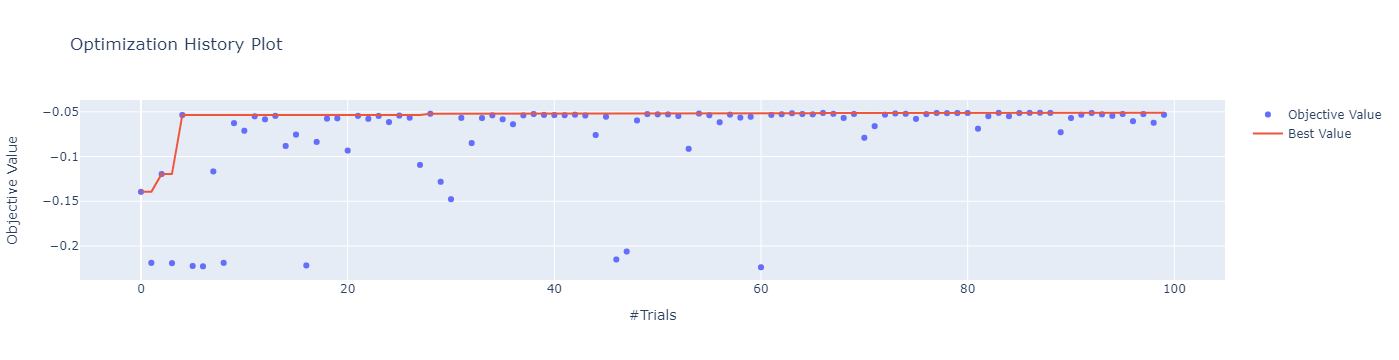

In [36]:
optuna.visualization.plot_optimization_history(study)

# Uncomment to write figure
# fig1 = optuna.visualization.plot_optimization_history(study)
# fig1.write_image('optuna_optimization_history_GB_PCA.png')

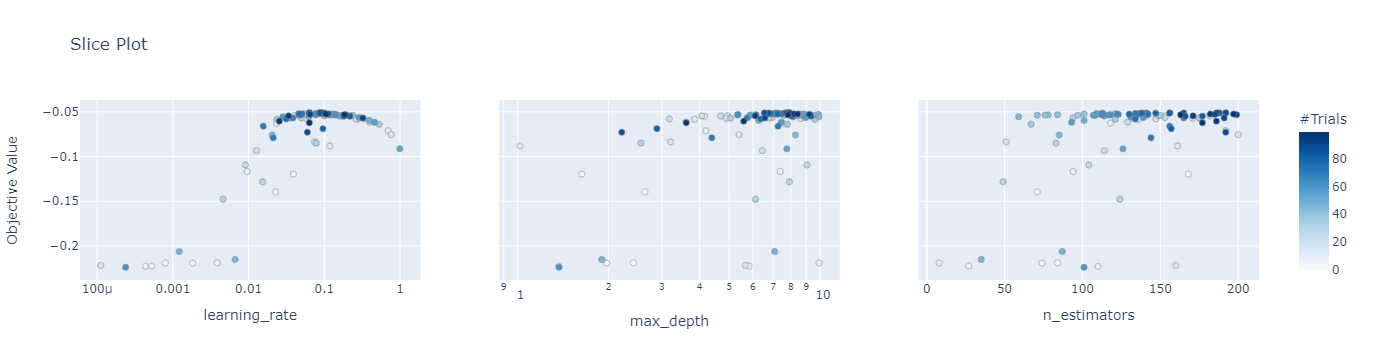

In [37]:
optuna.visualization.plot_slice(study)

# Uncomment to write figure
# fig2 = optuna.visualization.plot_slice(study)
# fig2.write_image('optuna_slice_plot_GB_PCA.png')

Information about the trails can be extracted from the study:

In [33]:
trial = study.best_trial
trial

FrozenTrial(number=87, values=[-0.05107531443090187], datetime_start=datetime.datetime(2021, 8, 15, 22, 55, 45, 230322), datetime_complete=datetime.datetime(2021, 8, 15, 22, 57, 35, 173089), params={'n_estimators': 187, 'max_depth': 7.920281630913733, 'learning_rate': 0.06374800807435875}, distributions={'n_estimators': IntUniformDistribution(high=200, low=2, step=1), 'max_depth': LogUniformDistribution(high=10.0, low=1.0), 'learning_rate': LogUniformDistribution(high=1.0, low=0.0001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=87, state=TrialState.COMPLETE, value=None)

#### Submission

Try creating a csv file for submission using the optimized hyperparameters


In [40]:
# Get hyperparams from best trial
trial = study.best_trial

# Set up model
model = ensemble.GradientBoostingRegressor(n_estimators=trial.params['n_estimators'], max_depth=trial.params['max_depth'], learning_rate=trial.params['learning_rate'])

model.fit(X_train, y_train)

preds = model.predict(test_descriptors_PCA)

In [41]:
preds.shape

(3363,)

In [42]:
np.savetxt("task_1_predictions_GB_PCA.csv", preds)